## Risk management: market risk

### Overview

- get logarithmic return data
- check assumption of normality
- *VaR* and *ES* estimation
- backtesting
- simulation study: estimation risk

## Basic setup

- loading required packages
- optional: install missing packages with `Pkg.add()`

In [1]:
# Pkg.add("EconDatasets")
# Pkg.add("TimeData")

using EconDatasets
using TimeData
using Dates
using Gadfly
using Distributions
using JuMP
using NLopt
using Base.Test

    get(Any,Colon) at /home/jovyan/.julia/v0.3/TimeData/src/abstractFuncs.jl:77
is ambiguous with: 
    get(Nullable{T},Any) at /home/jovyan/.julia/v0.3/Compat/src/nullable.jl:39.
To fix, define 
    get(Nullable{T},Colon)
before the new definition.
    get(Any,Colon) at /home/jovyan/.julia/v0.3/TimeData/src/abstractFuncs.jl:77
is ambiguous with: 
    get(OrderedDict{K,V},Any...) at /home/jovyan/.julia/v0.3/DataStructures/src/delegate.jl:11.
To fix, define 
    get(OrderedDict{K,V},Colon)
before the new definition.
    get(Any,Colon) at /home/jovyan/.julia/v0.3/TimeData/src/abstractFuncs.jl:77
is ambiguous with: 
    get(DefaultDictBase{K,V,F,D},Any...) at /home/jovyan/.julia/v0.3/DataStructures/src/delegate.jl:11.
To fix, define 
    get(DefaultDictBase{K,V,F,D},Colon)
before the new definition.
    get(Any,Colon) at /home/jovyan/.julia/v0.3/TimeData/src/abstractFuncs.jl:77
is ambiguous with: 
    get(DefaultDict{K,V,F},Any...) at /home/jovyan/.julia/v0.3/DataStructures/src/delegate.j

## Get data

- **download** data from Yahoo Finance: NASDAQ-100, S&P 500 and EURO STOXX 50 

In [2]:
tickerSymbs = ["^NDX"
               "^GSPC"
               "^STOXX50E"]


dates = Date(1960,1,1):Date(2015,3,30)

indexData = [readYahooFinance(dates, symb) for symb in tickerSymbs];

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  519k    0  519k    0     0   505k      0 --:--:--  0:00:01 --:--:--  506k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  964k    0  964k    0     0   993k      0 --:--:-- --:--:-- --:--:--  993k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  385k    0  385k    0     0   536k      0 --:--:-- --:--:-- --:--:--  536k


- take a peek at data

In [3]:
## display first five dates of NASDAQ
indexData[2][1:5, :]

Timematr{Date}(5x6 DataFrame
| Row | Open  | High  | Low   | Close | Volume  | Adj_Close |
|-----|-------|-------|-------|-------|---------|-----------|
| 1   | 16.66 | 16.66 | 16.66 | 16.66 | 1260000 | 16.66     |
| 2   | 16.85 | 16.85 | 16.85 | 16.85 | 1890000 | 16.85     |
| 3   | 16.93 | 16.93 | 16.93 | 16.93 | 2550000 | 16.93     |
| 4   | 16.98 | 16.98 | 16.98 | 16.98 | 2010000 | 16.98     |
| 5   | 17.08 | 17.08 | 17.08 | 17.08 | 2520000 | 17.08     |,[1950-01-03,1950-01-04,1950-01-05,1950-01-06,1950-01-09])

### Select single index

- create lookup table to be able to select index data by name:

In [4]:
lookUpIndices = {:nasdaq => 1, :sp500 => 2, :stoxx => 3}

Dict{Any,Any} with 3 entries:
  :nasdaq => 1
  :sp500  => 2
  :stoxx  => 3

- select index of interest

In [5]:
chosenIndex = :nasdaq

:nasdaq

- extract **adjusted closing prices** for a single index
- **rename** column to index name

In [6]:
indexPriceData = indexData[lookUpIndices[chosenIndex]][:Adj_Close]
rename!(indexPriceData.vals, :Adj_Close, chosenIndex)

indexPriceData[1:5, :]

Timematr{Date}(5x1 DataFrame
| Row | nasdaq  |
|-----|---------|
| 1   | 112.14  |
| 2   | 110.825 |
| 3   | 110.87  |
| 4   | 110.075 |
| 5   | 108.2   |,[1985-10-01,1985-10-02,1985-10-03,1985-10-04,1985-10-07])

### Plot price data

- enable plotting for `TimeData` instances:

In [7]:
loadPlotting()

wstHist (generic function with 4 methods)

- plot historic price data

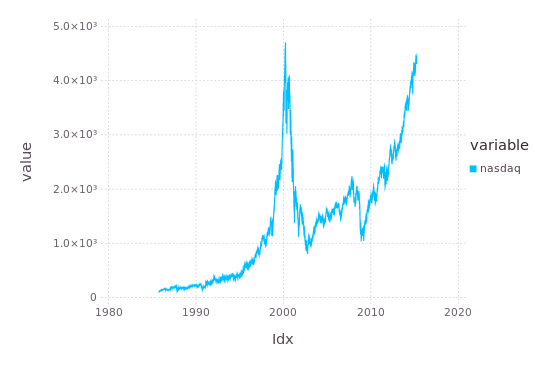

In [8]:
gdfPlot(indexPriceData)

- same plot with **logarithmic prices**

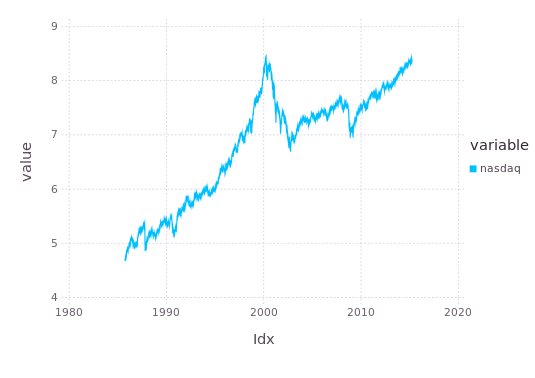

In [9]:
gdfPlot(log(indexPriceData))

### Plot returns

- calculate discrete and logarithmic returns

In [10]:
function calcDiscRet(tm::Timematr)
    return 100*(tm[2:end, :] .- tm[1:(end-1), :])./tm[1:(end-1), :]
end

function calcLogRet(tm::Timematr)
    return 100*(log(tm[2:end, :]) .- log(tm[1:(end-1), :]))
end

calcLogRet (generic function with 1 method)

In [11]:
indexRetData = calcLogRet(indexPriceData)
indexRetData[1:5; :]

Timematr{Date}(5x1 DataFrame
| Row | nasdaq    |
|-----|-----------|
| 1   | -1.17957  |
| 2   | 0.0405963 |
| 3   | -0.719639 |
| 4   | -1.71806  |
| 5   | -0.965832 |,[1985-10-02,1985-10-03,1985-10-04,1985-10-07,1985-10-08])

- plotting logarithmic return data: returns exhibit **volatility clusters**

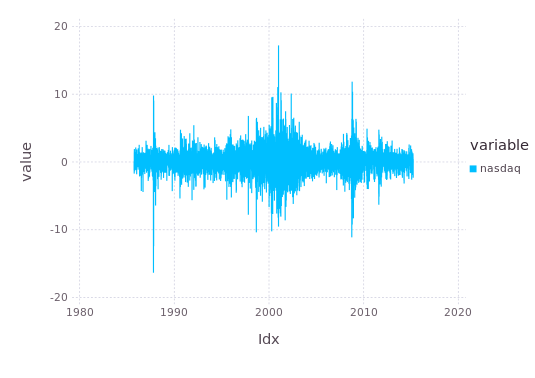

In [12]:
gdfPlot(indexRetData)

## Logarithmic return distribution

- extract return data without metadata

In [13]:
logRets = asArr(indexRetData, Float64)[:];

- display histogram

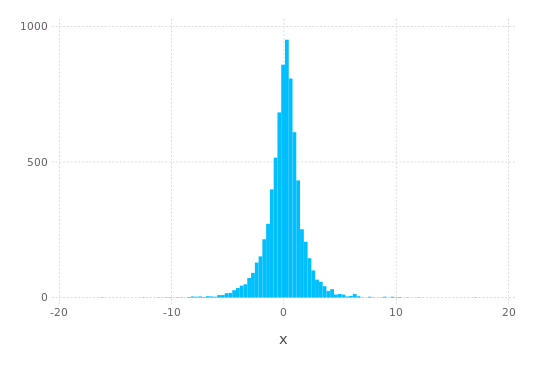

In [14]:
plot(x=logRets, Geom.histogram(bincount = 100))

### fit normal distribution

pdf:

$$
\begin{equation*}
f(x_{i};\mu,\sigma)=\frac{1}{\sqrt{2 \pi \sigma^{2}}}\exp\left(-\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)
\end{equation*}
$$

- log-likelihood function

$$
\begin{align*}
\ln(f(x_{i};\mu,\sigma))&=\ln\left((2\pi \sigma^{2})^{-\frac{1}{2}}\exp\left(-\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)\right)\\
&=\ln\left((2\pi \sigma^{2})^{-\frac{1}{2}}\right) + \ln\left(\exp\left(-\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)\right)\\
&=-\frac{1}{2}\ln\left(2\pi \sigma^{2}\right) - \left(\frac{(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)
\end{align*}
$$

- implementation

In [15]:
function norm_negLlh(x::Array{Float64, 1}, mu::Float64, sigma::Float64)
    llhs = -0.5*log(sigma^2*2*pi)-0.5*(x-mu).^2/sigma^2
    return return -sum(llhs)
end

norm_negLlh (generic function with 1 method)

- **test** negative log-likelihood with built-in function

In [16]:
normDist = Normal(0., 1.0)

@test_approx_eq -sum(log(pdf(normDist, logRets))) norm_negLlh(logRets, 0., 1.)

- determine **objective function**

In [17]:
count = 0 # keep track of number of function evaluations

function objFunc(x::Vector, grad::Vector)
    if length(grad) > 0
    end

    global count
    count::Int += 1
    # println("f_$count($x)")
    
    mu = x[1]
    sigma = x[2]

    return norm_negLlh(logRets, mu, sigma)
end

objFunc (generic function with 1 method)

- **fit** normal distribution using NLopt

In [18]:
opt = Opt(:LN_COBYLA, 2)
lower_bounds!(opt, [-Inf, 0.])
xtol_rel!(opt,1e-8)

min_objective!(opt, objFunc)

(minf,minx,ret) = optimize(opt, [0.0, 1.0])
println("got $minf at $minx after $count iterations (returned $ret)")

got 14526.376576784487 at [0.04915571949192298,1.7076314260696241] after 67 iterations (returned XTOL_REACHED)


- compare result to built-in function

In [19]:
normFit = fit(Normal, logRets)

Normal(μ=0.0491557033633773, σ=1.7076314274539048)

- unit test

In [20]:
muHat, sigmaHat = minx

muHat_builtin, sigmaHat_builtin = params(normFit)

@test_approx_eq_eps muHat muHat_builtin 0.0000001
@test_approx_eq_eps sigmaHat sigmaHat_builtin 0.0000001

### Comparison with empirical distribution

- calculate values of empirical cdf:

In [21]:
function ecdfVals(x::Array{Float64, 1})
    xVals = sort(x)
    nObs = size(x, 1)
    yVals = [1:nObs]./(1+nObs)
    return (xVals, yVals)
end

xVals, yVals = ecdfVals(logRets);

- plot ecdf together with cdf of fitted normal distribution:

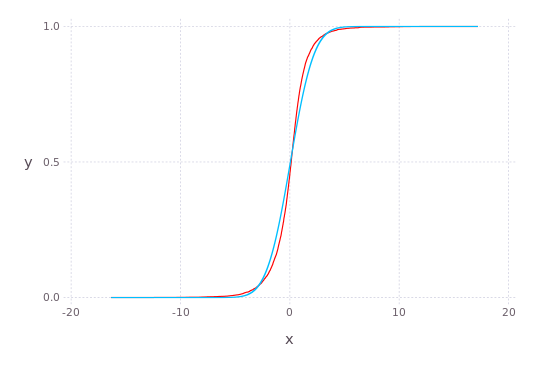

In [22]:
# calculate values of normal cdf
nCdfVals = cdf(normFit, xVals)

plot(layer(x=xVals, y=nCdfVals, Geom.step),
layer(x=xVals, y=yVals, Geom.line, Theme(default_color=color("red"))))

### qq-plot

- compare quantiles of fitted normal distribution with empirical quantiles

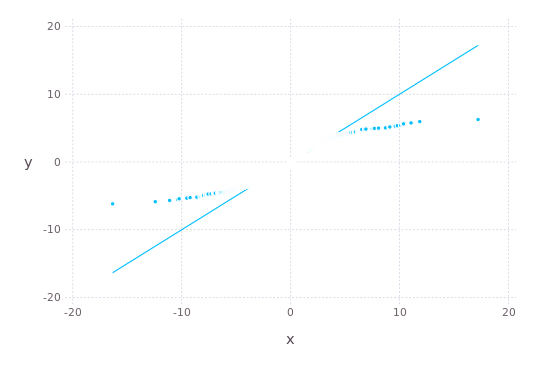

In [23]:
normVals = quantile(normFit, yVals)

plot(layer(x=xVals, y=normVals, Geom.point,Theme(default_point_size=0.6mm)),
layer(x=[minimum(xVals), maximum(xVals)], y=[minimum(xVals), maximum(xVals)], Geom.line))

# *VaR* and *ES*

### Historical simulation

- *VaR*:

In [24]:
alpha = 0.98
logLosses = -logRets

varHS = quantile(logLosses, alpha)

3.8419575995586728

- expected shortfall:

In [25]:
function empES(x::Array{Float64, 1}, alphas::Array{Float64, 1})
    nVars = length(alphas)
    varHS = quantile(x, alphas)
    esHS = Array(Float64, nVars)
        
    for ii=1:nVars
        exceedances = x[x .> varHS[ii]]
        esHS[ii] = mean(exceedances)
    end
    return esHS
end

empES(logLosses, [alpha])

1-element Array{Float64,1}:
 5.42294

### Under normality

- *VaR*: using

\begin{equation*}
\text{VaR}_{\alpha}=\mu_{L}+\sigma\Phi^{-1}(\alpha)
\end{equation*}


In [26]:
muL = -muHat
sigma = sigmaHat
varNorm = muL + sigma*quantile(Normal(), alpha)

3.4578904615592325

- expected shortfall: using

\begin{equation*}
\text{ES}_{\alpha}=\mu_{L}+\sigma \frac{\phi\left( \Phi^{-1}(\alpha) \right) }{1-\alpha}
\end{equation*}


In [27]:
esNorm = muL + sigma*(pdf(Normal(), quantile(Normal(), alpha))/(1-alpha))

4.084860801591298

In [28]:
varNorm = quantile(normFit, alpha)

(varHS, varNorm)

(3.8419575995586728,3.5562018872574974)

# Model risk

- given that returns in the real world were indeed generated by an underlying normal distribution, we could determine the risk inherent to the investment up to a small error arising from **estimation errors**
- however, returns of the real world are **not normally distributed**
- in addition to the risk deduced from the model, the model itself could be significantly different to the processes of the real world that are under consideration
- the risk of deviations of the specified model from the real world is called **model risk**


### Backtesting

- calculate hit rates for *VaR* under normality:

In [29]:
hitsNorm = sum(logLosses .> varNorm)./size(logLosses, 1)

println("Instead of $(1-alpha) exceedances, we get:")
println("   using normality:       $hitsNorm")

Instead of 0.020000000000000018 exceedances, we get:
   using normality:       0.026365348399246705


- visualize backtesting

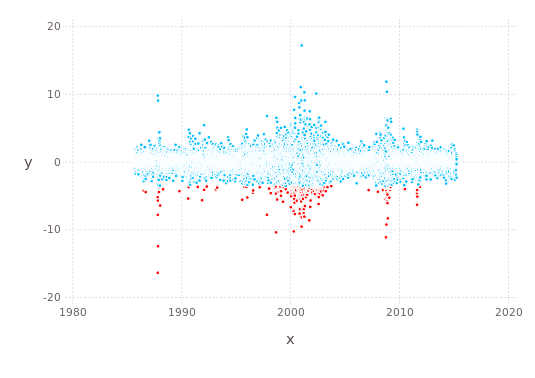

In [30]:
exceedInd = asArr(-indexRetData .> varNorm, Bool, false)[:]
exceedances = indexRetData[exceedInd, :]
noExceedances = indexRetData[!exceedInd, :]

plot(layer(x=idx(noExceedances), y=asArr(noExceedances, Float64), 
Geom.point, Theme(default_point_size=0.5mm)),
layer(x=idx(exceedances), y=asArr(exceedances, Float64), 
Geom.point, Theme(default_color=color("red"), default_point_size=0.5mm)))

- backtesting *VaR*-calculations based on assumption of independent normally distributed losses generally leads to   two patterns:
    - percentage frequencies of *VaR*-exceedances are higher than the confidence levels specified: normal distribution assigns too less probability to large losses
    - *VaR*-exceedances occur in clusters: given an exceedance of VaR today, the likelihood of an additional exceedance in the days following is larger than average

- the results of the backtesting procedure indicate substantial model risk involved in the framework of assumed normally distributed losses

- clustered exceedances indicate violation of independence of losses over time
$\Rightarrow$ clusters have to be captured through time series models

- backtesting historical simulation *VaR*:

In [31]:
hitsHS = sum(logLosses .> varHS)./size(logLosses, 1)

println("Instead of $(1-alpha) exceedances, we get:")
println("   historical simulation: $hitsHS")

Instead of 0.020000000000000018 exceedances, we get:
   historical simulation: 0.02004304546677428


- **Note**: exceedance frequencies for historical simulation equal predefined confidence level per definition 

$\Rightarrow$ overfitting

# Simulation study: estimation error

- historical simulation does not entail any model risk
- backtesting historical simulation always shows perfectly accurate in-sample frequencies

$\Rightarrow$ is historical simulation the best *VaR* estimator?

- although historical simulation does not entail model risk, the associated estimation risk can be huge
- for example, with 2500 observations, only 2.5 observations are above $VaR_{0.999}$

Simulation study:
- take some return distribution as given $\Rightarrow$ *VaR* is known
- simulate sample of given size
- estimate *VaR* for given sample with historical simulation
- repeat procedure to get distribution of historical simulation estimator

In [32]:
distr = TDist(3)
alphas = [0.99, 0.995, 0.999]

nReps = 100000
nObs = 2500

# preallocation
simVals = Array(Float64, nObs)

simVar = Array(Float64, nReps, length(alphas))

@time begin
    for ii=1:nReps
        simVals = rand(distr, nObs)
        simVar[ii, :] = quantile(simVals, alphas)
    end
end

elapsed time: 56.254995155 seconds (5627688420 bytes allocated, 14.34% gc time)


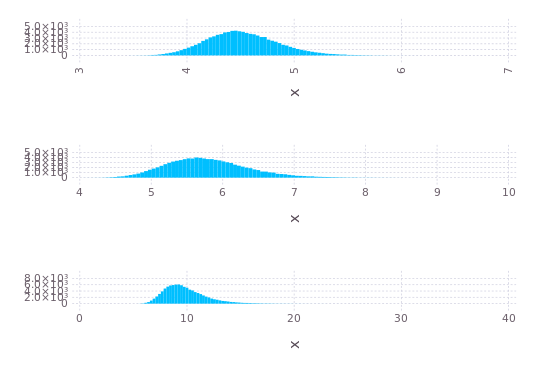

In [33]:
ps = [plot(x=simVar[:, ii][:], Geom.histogram(bincount = 100)) for ii=1:length(alphas)]

vstack(ps...)

- given the distribution of our historical simulation estimator, we can evaluate mean squared error as a measure of deviation from the true value

In [34]:
trueVars = quantile(distr, alphas)

mserrors = Float64[mean((simVar[:, ii] - trueVars[ii]).^2) for ii=1:length(alphas)]

3-element Array{Float64,1}:
 0.112282
 0.334593
 4.19842 

# Reproduction info

In [35]:
versioninfo()

Julia Version 0.3.6
Commit a05f87b* (2015-01-08 22:33 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i5-4210U CPU @ 1.70GHz
  WORD_SIZE: 64
  BLAS: libopenblas (DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


In [36]:
Pkg.status()

19 required packages:
 - DataArrays                    0.2.13
 - DataFrames                    0.6.3
 - Dates                         0.3.2
 - Debug                         0.1.2
 - Distributions                 0.7.0
 - EconDatasets                  0.0.2
 - GLM                           0.4.5
 - Gadfly                        0.3.11
 - IJulia                        0.2.3
 - JuMP                          0.9.0
 - MAT                           0.2.11
 - NLopt                         0.2.0
 - Plotly                        0.0.3+             master
 - Quandl                        0.4.1
 - RDatasets                     0.1.2
 - Taro                          0.1.4
 - TimeData                      0.5.1
 - TimeSeries                    0.5.7
 - Winston                       0.11.9
57 additional packages:
 - ArrayViews                    0.6.1
 - BinDeps                       0.3.11
 - Blosc                         0.1.2
 - Cairo                         0.2.26
 - Calculus                    